# PD3
by Hanna Zdulska

In [121]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, recall_score, precision_score, plot_precision_recall_curve, mean_squared_error, r2_score
import seaborn as sns
import category_encoders as ce
np.random.seed(123)

In [2]:
df = pd.read_csv("../australia.csv")

In [3]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000
mean,13.464770,24.219206,2.130397,5.503135,7.735626,40.877366,15.667228,19.786778,65.874123,49.601985,1017.239505,1014.795580,4.241705,4.326515,18.204961,22.710333,0.220879,0.220259
std,6.416689,6.970676,7.014822,3.696282,3.758153,13.335232,8.317005,8.510180,18.513289,20.197040,6.909357,6.870892,2.797162,2.647251,6.567991,6.836543,0.414843,0.414425
min,-6.700000,4.100000,0.000000,0.000000,0.000000,9.000000,2.000000,2.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-0.700000,3.700000,0.000000,0.000000
25%,8.600000,18.700000,0.000000,2.800000,5.000000,31.000000,9.000000,13.000000,55.000000,35.000000,1012.700000,1010.100000,1.000000,2.000000,13.100000,17.400000,0.000000,0.000000
50%,13.200000,23.900000,0.000000,5.000000,8.600000,39.000000,15.000000,19.000000,67.000000,50.000000,1017.200000,1014.700000,5.000000,5.000000,17.800000,22.400000,0.000000,0.000000
75%,18.400000,29.700000,0.600000,7.400000,10.700000,48.000000,20.000000,26.000000,79.000000,63.000000,1021.800000,1019.400000,7.000000,7.000000,23.300000,27.900000,0.000000,0.000000
max,31.400000,48.100000,206.200000,81.200000,14.500000,124.000000,67.000000,76.000000,100.000000,100.000000,1040.400000,1038.900000,8.000000,9.000000,39.400000,46.100000,1.000000,1.000000


Podzielmy i przeskalujmy dane

In [ ]:
y = df['RainTomorrow']
X = df.drop('RainTomorrow', axis = 1)
X_scaled = scale(X)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size = 0.3, random_state = 66)

Zrobimy szukanie najlepszego parametru, bo czemu nie

In [58]:
lr_params = {'C': [(i+1)/10 for i in range(0,10)]}
kn_params = {'n_neighbors': [i+1 for i in range(10)]}
xgb_params = {'max_depth': [i+1 for i in range(10)]}

In [68]:
clffs = [GridSearchCV(LogisticRegression(), lr_params),
         GridSearchCV(KNeighborsClassifier(), kn_params),
         GridSearchCV(XGBClassifier(), xgb_params)]

In [69]:
proba = []
for c in clffs:
    c.fit(X_train, y_train)
    proba.append(c.predict_proba(X_test)[:,1])

In [84]:
acc = []
auc = []
prec = []
rec = []
for i in range(3):
    y_pred = [ 0 if proba[0][i] < 0.5 else 1 for i in range(len(proba[i]))]
    acc.append(accuracy_score(y_test, y_pred))
    auc.append(roc_auc_score(y_test, proba[i]))
    rec.append(recall_score(y_test, y_pred))
    prec.append(precision_score(y_test, y_pred))

Spójrzmy na wyniki

/home/hania/.pyenv/versions/3.7.1/lib/python3.7/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


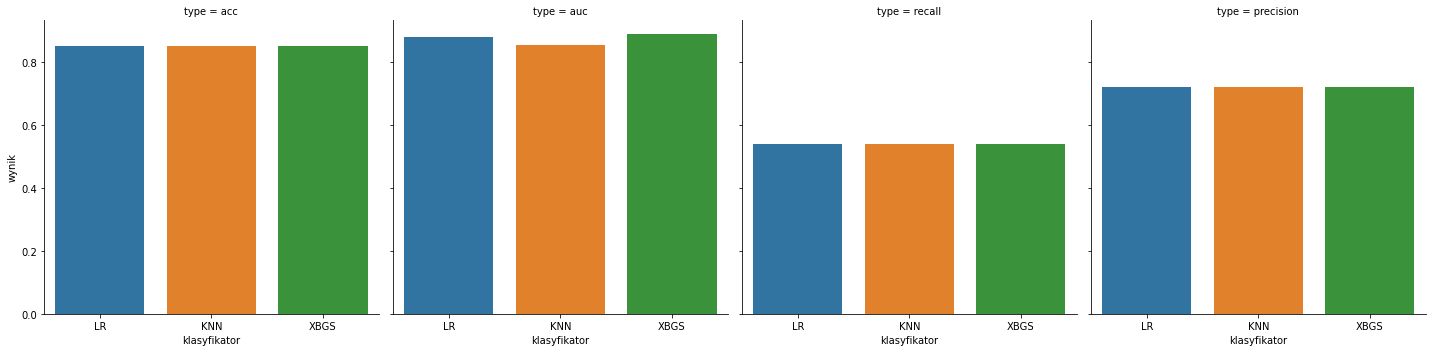

In [98]:
res_df = pd.DataFrame({"klasyfikator": ["LR","KNN","XBGS"]*4, "wynik": acc + auc + rec + prec,
                       "type": ["acc"]*3 + ["auc"]*3 + ["recall"]*3 + ["precision"]*3})
sns.factorplot("klasyfikator", "wynik", col="type", data = res_df, kind="bar" )

Jak widać większość radzi sobie podobnie, jedyne widoczne różnice gołym okiem to auc, które jest niższe dla KNN.

In [97]:
for i in range(3):
    print("AUC: {} - klasyfikator - {}".format(auc[i], ["LR","KNN","XBGS"][i]))

AUC: 0.8801109554523089 - klasyfikator - LR
AUC: 0.8555327514793168 - klasyfikator - KNN
AUC: 0.8878097143681737 - klasyfikator - XBGS


Zauważmy, że acc jest jednakowe dla wszystkich klasyfkiatorów tzn. wszystkie zaklasyfikowały tą samą ilość rekordów poprawnie.

In [106]:
len(set(rec))

1

In [107]:
len(set(prec))

1

Również powyżej zauważmy, iż mają ten sam recall i precision czyli zaklasyfikowały wszystkie tak samo tj. dały identyczne przewidywania klas.

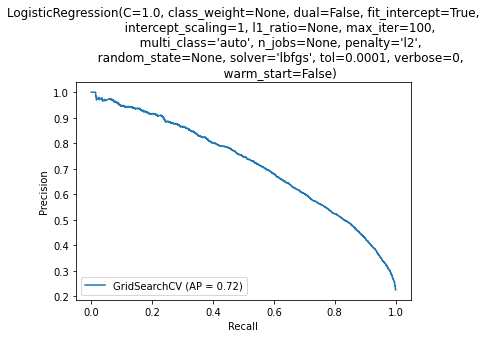

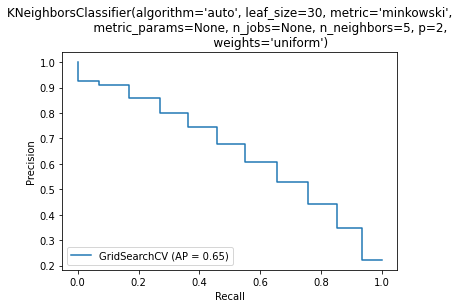

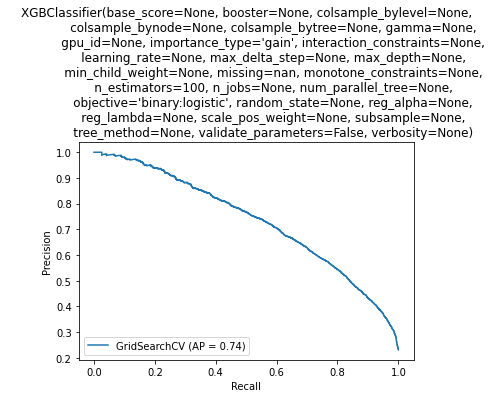

In [117]:
for c in clffs:
    plot = plot_precision_recall_curve(c, X_test, y_test)
    plot.ax_.set_title(c.estimator)

## Bonus round

Wczytanie danych

In [141]:
df = pd.read_csv('https://www.dropbox.com/s/360xhh2d9lnaek3/allegro-api-transactions.csv?dl=1')
df = df.drop(['lp', 'date'], axis = 1)
y = df['price']
columns = ['categories', 'seller','it_location', 'main_category']

Customowa funkcja:

In [173]:
def measure_encoder(encoder, *args):
    """
    Funkcja działająca jako pipeline w następujących krokach:
    * kodowanie
    * dopasowanie
    * liczenie rmse i r2
    """
    linreg = LinearRegression(*args)
    
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['price'], axis = 1),y, test_size = 0.3, random_state = 66)
    
    encoder.fit(X_train, y_train)
    
    X_train = encoder.transform(X_train)
    X_test = encoder.transform(X_test)
    
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    return rmse, r2

In [162]:
enc = [ce.OrdinalEncoder(cols = columns),
       ce.MEstimateEncoder(cols = columns),
       ce.TargetEncoder(cols = columns),
       ce.CatBoostEncoder(cols = columns), 
       ce.JamesSteinEncoder(cols = columns)]

Liczymy wyniki dla wybranych encoderów

In [174]:
res = pd.DataFrame(columns=["Name", "mrse", "R2"])
names = ['Ordinal', 'MEstimate', 'Target', 'CatBoost', 'JamesStein']
for i in range(len(enc)):
    mrse, r2 = measure_encoder(enc[i])
    res = res.append({"Name": names[i], "mrse": mrse, "R2": r2}, ignore_index = True)

In [175]:
res

,Name,mrse,R2
0,Ordinal,506.158248,0.002557
1,MEstimate,489.218646,0.068203
2,Target,490.791207,0.062203
3,CatBoost,490.977930,0.061489
4,JamesStein,494.601364,0.047586


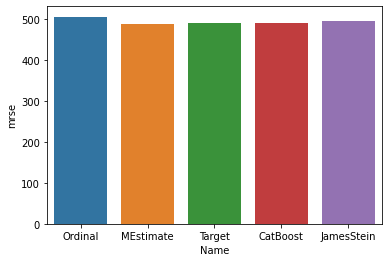

In [165]:
sns.barplot(data = res, y = 'mrse', x = 'Name')

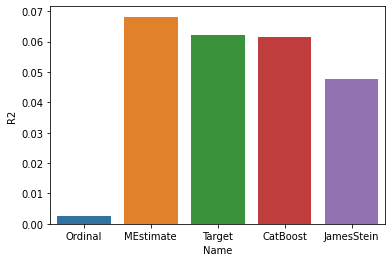

In [167]:
sns.barplot(data = res, y = 'R2', x = 'Name')

MRSE na poziomie 500, natomniast R2 jest bardzo małe, nieprzekraczające nawet 0.1. Jak widać najgorzej wypadł OrdinalEncoder  - osiągnął bardzo niskie R2 i najwyższe MRSE. 
Najniższe MRSE przypadło MEstimate, które wypadło równocześnie najlepiej w R2.
Poza rzucającym sie w oczy OrdinalEncoder, to większość modeli wypadło dośc podobnie.